In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.55, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

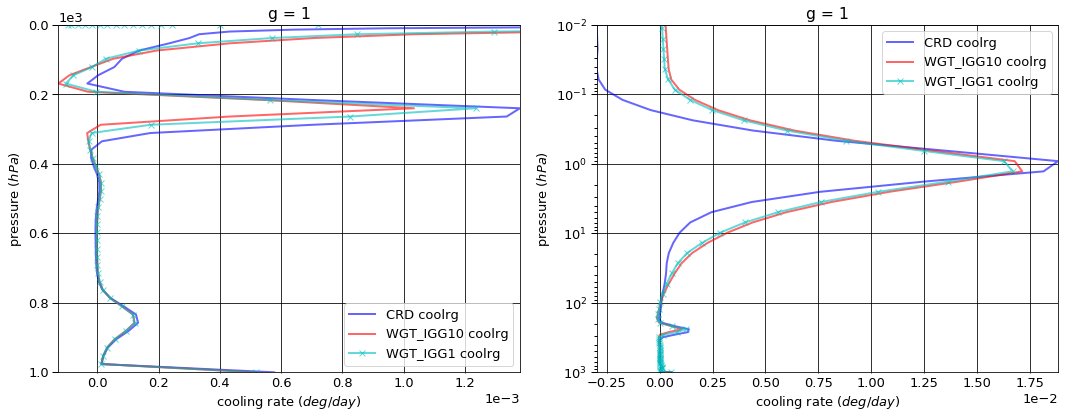

# Figure: cooling rate g-group 2

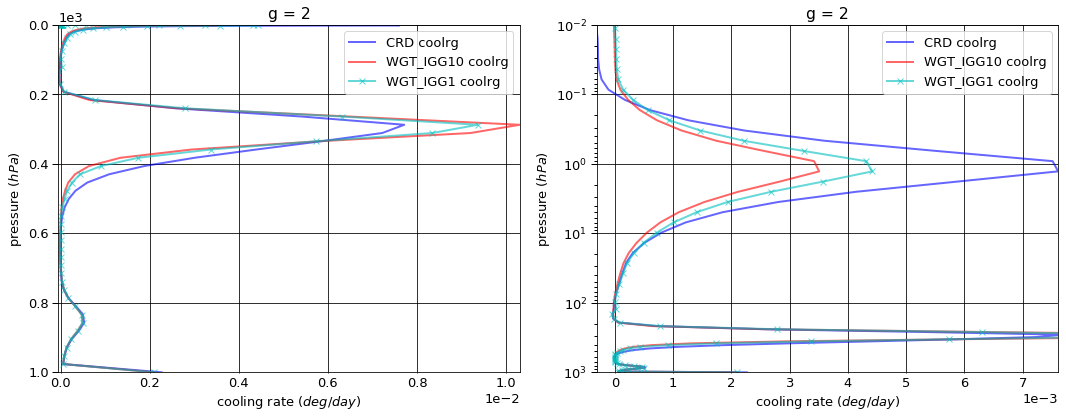

# Figure: cooling rate g-group 3

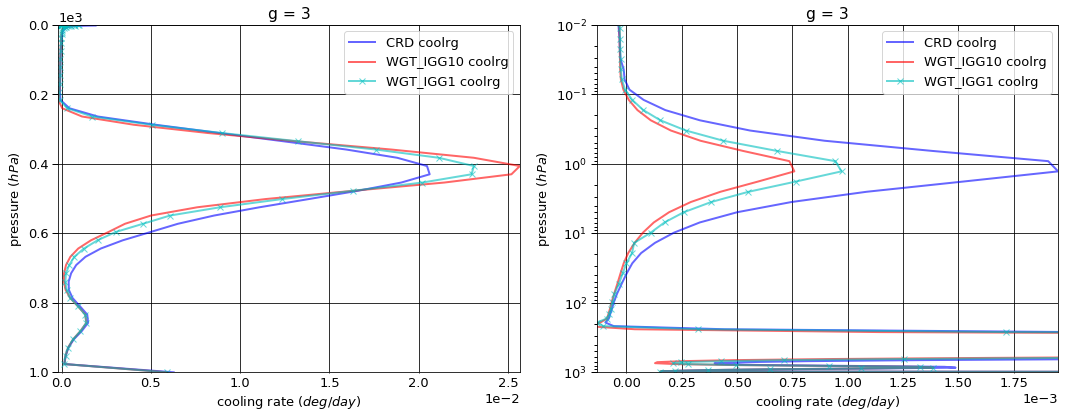

# Figure: cooling rate g-group 4

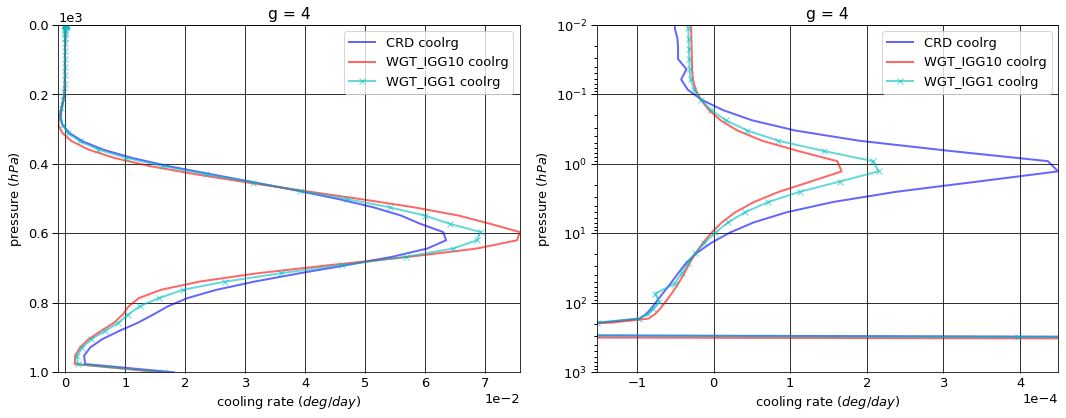

# Figure: cooling rate g-group 5

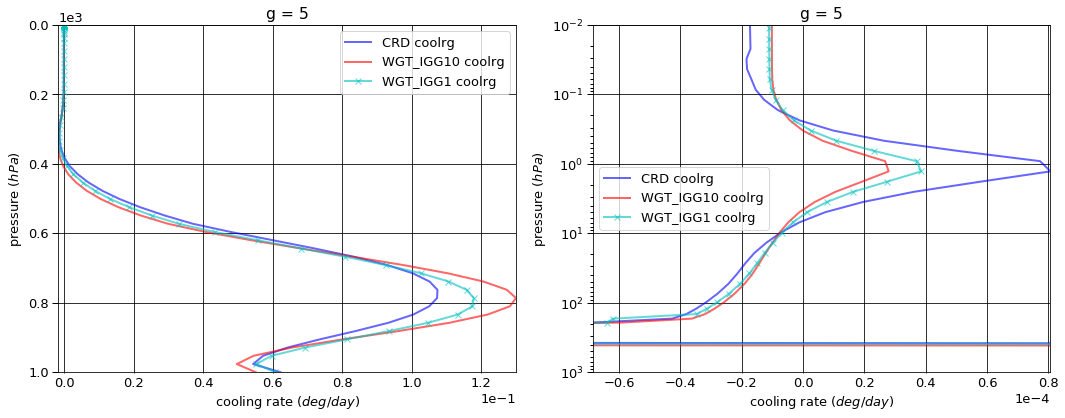

# Figure: cooling rate g-group 6

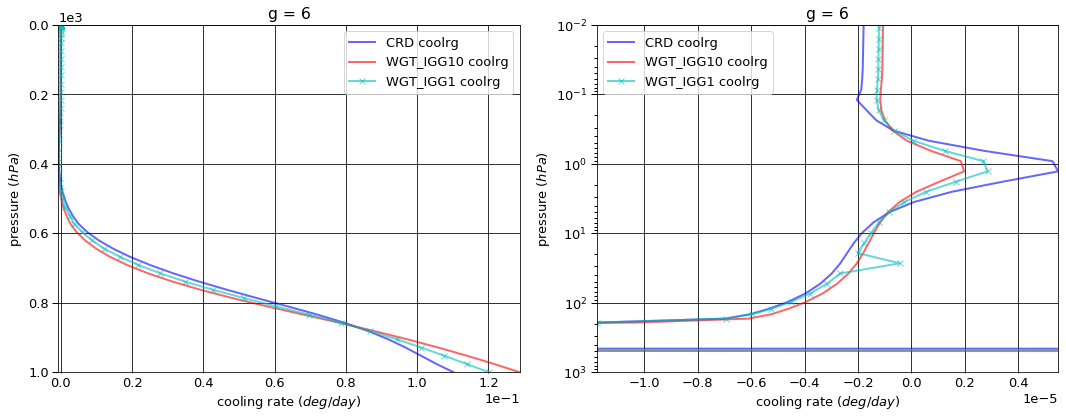

# Figure: cooling rate g-group 7

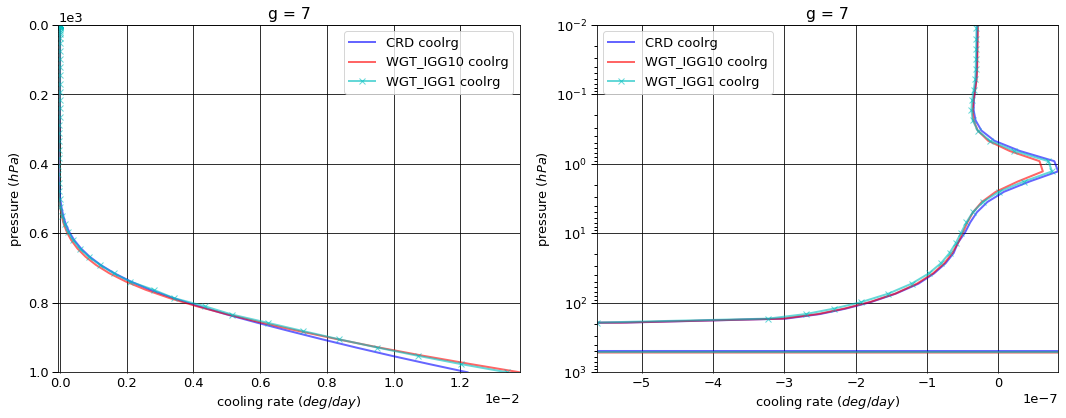

# Figure: cooling rate g-group total

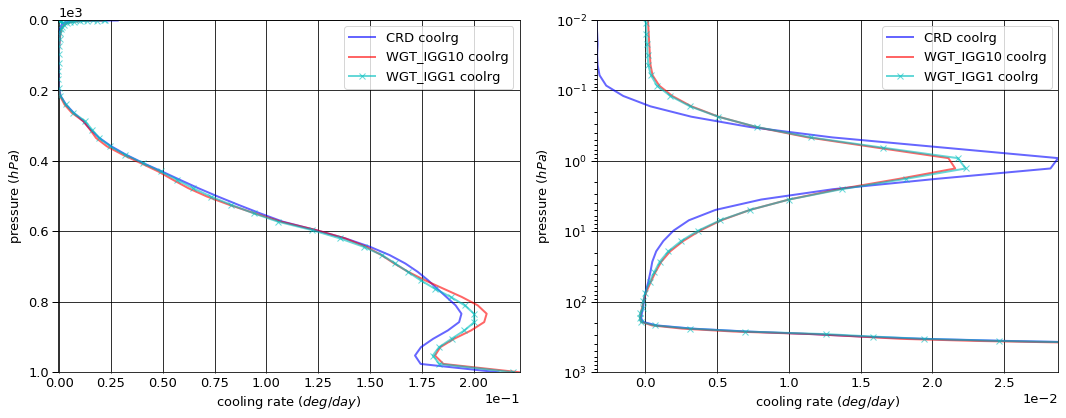

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025591  0.000000 -0.025591
  1013.0   76    -0.174679  0.173061 -0.001618
2 0.0      1     -0.139695  0.000000 -0.139695
  1013.0   76    -0.694422  0.688074 -0.006349
3 0.0      1     -0.602854  0.000000 -0.602854
  1013.0   76    -1.939097  1.921502 -0.017595
4 0.0      1     -2.405402  0.000000 -2.405402
  1013.0   76    -5.006750  4.951599 -0.055151
5 0.0      1     -4.953116  0.000000 -4.953116
  1013.0   76    -7.187588  6.719818 -0.467770
6 0.0      1     -6.251185  0.000000 -6.251185
  1013.0   76    -6.979252  3.725164 -3.254088
7 0.0      1     -1.730139  0.000000 -1.730139
  1013.0   76    -1.773387  0.283276 -1.490111


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024590  0.000000 -0.024590
  1013.0   76    -0.164658  0.163208 -0.001450
2 0.0      1     -0.135348  0.000000 -0.135348
  1013.0   76    -0.664847  0.658993 -0.005854
3 0.0      1     -0.587052  0.000000 -0.587052
  1013.0   76    -1.873925  1.857425 -0.016500
4 0.0      1     -2.361426  0.000000 -2.361426
  1013.0   76    -4.863491  4.818226 -0.045266
5 0.0      1     -4.993700  0.000000 -4.993700
  1013.0   76    -7.158282  6.881338 -0.276944
6 0.0      1     -6.516536  0.000000 -6.516536
  1013.0   76    -7.166936  3.625183 -3.541754
7 0.0      1     -1.817862  0.000000 -1.817862
  1013.0   76    -1.863037  0.296444 -1.566592


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025277  0.000000 -0.025277
  1013.0   76    -0.164658  0.163208 -0.001450
2 0.0      1     -0.135465  0.000000 -0.135465
  1013.0   76    -0.664847  0.658993 -0.005854
3 0.0      1     -0.587107  0.000000 -0.587107
  1013.0   76    -1.873925  1.857425 -0.016500
4 0.0      1     -2.356171  0.000000 -2.356171
  1013.0   76    -4.863491  4.816534 -0.046958
5 0.0      1     -4.973529  0.000000 -4.973529
  1013.0   76    -7.158282  6.814045 -0.344237
6 0.0      1     -6.462910  0.000000 -6.462910
  1013.0   76    -7.166936  3.684112 -3.482824
7 0.0      1     -1.815668  0.000000 -1.815668
  1013.0   76    -1.863037  0.301104 -1.561933


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001001  0.000000  0.001001
  1013.0   76     0.010021 -0.009852  0.000168
2 0.0      1      0.004347  0.000000  0.004347
  1013.0   76     0.029576 -0.029081  0.000495
3 0.0      1      0.015803  0.000000  0.015803
  1013.0   76     0.065173 -0.064078  0.001095
4 0.0      1      0.043976  0.000000  0.043976
  1013.0   76     0.143259 -0.133373  0.009886
5 0.0      1     -0.040584  0.000000 -0.040584
  1013.0   76     0.029307  0.161520  0.190827
6 0.0      1     -0.265351  0.000000 -0.265351
  1013.0   76    -0.187684 -0.099982 -0.287666
7 0.0      1     -0.087724  0.000000 -0.087724
  1013.0   76    -0.089650  0.013168 -0.076481


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000314  0.000000  0.000314
  1013.0   76     0.010021 -0.009852  0.000168
2 0.0      1      0.004230  0.000000  0.004230
  1013.0   76     0.029576 -0.029081  0.000495
3 0.0      1      0.015748  0.000000  0.015748
  1013.0   76     0.065173 -0.064078  0.001095
4 0.0      1      0.049231  0.000000  0.049231
  1013.0   76     0.143259 -0.135065  0.008194
5 0.0      1     -0.020413  0.000000 -0.020413
  1013.0   76     0.029307  0.094227  0.123534
6 0.0      1     -0.211726  0.000000 -0.211726
  1013.0   76    -0.187684 -0.041052 -0.228737
7 0.0      1     -0.085529  0.000000 -0.085529
  1013.0   76    -0.089650  0.017828 -0.071822

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.134625e-03
  1001.112500 75     5.770577e-04
2 0.000312    1     -3.507886e-04
  1001.112500 75     2.265116e-03
3 0.000312    1     -4.953082e-05
  1001.112500 75     6.278506e-03
4 0.000312    1     -5.355406e-05
  1001.112500 75     1.808830e-02
5 0.000312    1     -1.770566e-05
  1001.112500 75     6.230348e-02
6 0.000312    1     -1.711666e-06
  1001.112500 75     1.102982e-01
7 0.000312    1     -2.758272e-08
  1001.112500 75     1.221389e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      6.496553e-05
  1001.112500 75     5.177849e-04
2 0.000312    1     -4.978766e-05
  1001.112500 75     2.090682e-03
3 0.000312    1     -3.710910e-05
  1001.112500 75     5.892756e-03
4 0.000312    1     -3.125374e-05
  1001.112500 75     1.603206e-02
5 0.000312    1     -1.024970e-05
  1001.112500 75     5.517586e-02
6 0.000312    1     -1.007880e-06
  1001.112500 75     1.288224e-01
7 0.000312    1     -2.683822e-08
  1001.112500 75     1.378229e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -9.436444e-05
  1001.112500 75     5.177849e-04
2 0.000312    1     -4.169076e-05
  1001.112500 75     2.090682e-03
3 0.000312    1     -3.754945e-05
  1001.112500 75     5.892756e-03
4 0.000312    1     -3.553112e-05
  1001.112500 75     1.639420e-02
5 0.000312    1     -1.125753e-05
  1001.112500 75     6.069518e-02
6 0.000312    1     -1.155148e-06
  1001.112500 75     1.201526e-01
7 0.000312    1     -2.866046e-08
  1001.112500 75     1.339893e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.199591e-03
  1001.112500 75    -5.927281e-05
2 0.000312    1      3.010009e-04
  1001.112500 75    -1.744349e-04
3 0.000312    1      1.242172e-05
  1001.112500 75    -3.857500e-04
4 0.000312    1      2.230032e-05
  1001.112500 75    -2.056235e-03
5 0.000312    1      7.455957e-06
  1001.112500 75    -7.127616e-03
6 0.000312    1      7.037858e-07
  1001.112500 75     1.852426e-02
7 0.000312    1      7.445050e-10
  1001.112500 75     1.568407e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.040261e-03
  1001.112500 75    -5.927281e-05
2 0.000312    1      3.090978e-04
  1001.112500 75    -1.744349e-04
3 0.000312    1      1.198137e-05
  1001.112500 75    -3.857500e-04
4 0.000312    1      1.802294e-05
  1001.112500 75    -1.694094e-03
5 0.000312    1      6.448125e-06
  1001.112500 75    -1.608297e-03
6 0.000312    1      5.565178e-07
  1001.112500 75     9.854420e-03
7 0.000312    1     -1.077732e-09
  1001.112500 75     1.185041e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.107982,0.000000,-16.107982
1013.0,76,-23.755176,18.462493,-5.292683



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.436514,0.000000,-16.436514
1013.0,76,-23.755176,18.300816,-5.454359



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.356127,0.00000,-16.356127
1013.0,76,-23.755176,18.29542,-5.459755



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.285319e-01,0.000000,-0.328532
1013.0,76,-2.000000e-08,-0.161677,-0.161677



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.481455e-01,0.000000,-0.248145
1013.0,76,-2.000000e-08,-0.167073,-0.167073


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003608
1001.112500,75,0.212025



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000064
1001.112500,75,0.222314



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000222
1001.112500,75,0.219142



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003543
1001.112500,75,0.010289



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003386
1001.112500,75,0.007118


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008727,0.006931
2,0.033164,0.027987
3,0.090315,0.078885
4,0.229558,0.204734
5,0.305091,0.301336
6,0.269358,0.301700
7,0.063788,0.078427


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.634434e-20
2,2.348017e-21
3,3.373146e-22
4,4.845840e-23
5,6.961502e-24
6,1.000085e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.634434e-20,NaN,0.008727,0.006931,0.008727,0.006931,600.0
2,2.348017e-21,0.143659,0.033164,0.027987,0.041891,0.034919,600.0
3,3.373146e-22,0.143659,0.090315,0.078885,0.132206,0.113804,600.0
4,4.845840e-23,0.143659,0.229558,0.204734,0.361764,0.318538,600.0
5,6.961502e-24,0.143659,0.305091,0.301336,0.666855,0.619873,600.0
6,1.000085e-24,0.143659,0.269358,0.301700,0.936212,0.921573,600.0
7,1.858499e-25,0.185834,0.063788,0.078427,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
